# EXPERIMENTO 3 - MFCC MOM


Exploramos la carpeta audio para conseguir los archivos y a la vez, extraemos los coeficientes mfccs


In [162]:
import numpy as np                 # Numpy: módulo fundamental de python para poder operar
import matplotlib.pyplot as plt    # Para poder pintar gráficas
%matplotlib inline
import os
import librosa 
import librosa.display
import IPython.display


fpaths = []       # fpaths:  'audio/apple/apple07.wav'  array path de carpeta 'audio'
labels = []       # labels: array palabras repetidas (7 veces apple, 7 veces kiwi.. etc)
spoken = []       # spoken: array palabras (no repetidas)
all_obs = []

for f in os.listdir("audio"):  # os.listdir: nos permite buscar en una ruta determinada
                               #   (nosotros buscamos f que seria las palabras habladas)
    if f not in ".DS_Store":
        for w in os.listdir("audio/" + f):
            fpaths.append("audio/" + f + '/' + w)
            labels.append(f)
            if f not in spoken:
                spoken.append(f)
                
print ('Words spoken:', spoken)

from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000)) # np.zeros: devuelve una nueva matriz rellena con ceros de una longitud len(fpaths)

# Cada archivo es una fila en datos y tiene una entrada de etiquetas
print ('Number of files total:', data.shape[0])

all_labels = np.zeros(data.shape[0])     #Conseguimos una matriz de 105 elementos rellenados con 0 (np.zeros)
print
print ('Matriz all_labels comienzo: ', all_labels)


for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n   


print ('Matriz etiquetada : ', all_labels)


maxsize = -1
all_obs = []

for n,file in enumerate(fpaths):    # Con enumerate vamos a enumerar la cantidad de path que hay fpaths 
                            # (conseguimos asi los 105 archivos)
   # fs, d = wavfile.read(file)     # Asi leíamos los audios en los experimentos anteriores
    x, fs = librosa.load(file, sr=8000)
    data[n, :x.shape[0]] = x  
    #print(x.shape[0])
    if x.shape[0] > maxsize:
        maxsize = x.shape[0]
        
data = data[:, :maxsize]
print(maxsize)
        
for n,file in enumerate(fpaths):    # Con enumerate vamos a enumerar la cantidad de path que hay fpaths 
    n_dim = 20 #numero de mfccs
    n_cases = len(fpaths)#numero de ejemplos
    s=librosa.feature.melspectrogram(data[n,:], sr=fs, n_fft=1024, hop_length=156)
    mfccs = np.zeros((n_dim, n_cases))      
    mfccs = librosa.feature.mfcc(data[n,:], sr=fs, S=s, n_mfcc=n_dim)
    print(mfccs.shape)  #Va cogiendo los 20 mfcc de cada audio
    
    all_obs.append(mfccs)    # Añadimos los mfcc
   
    if n % 10 == 0:
        print("Processed obs %s" % n)

               
all_obs = np.atleast_3d(all_obs)
print
print "Matriz Resultante :" , all_obs.shape
print
print(all_obs.shape)

('Words spoken:', ['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach'])
('Number of files total:', 105)

('Matriz all_labels comienzo: ', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]))
('Matriz etiquetada : ', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 

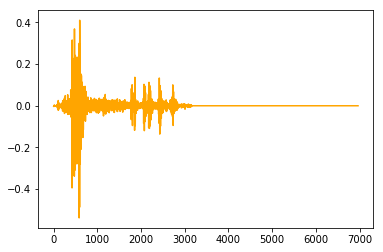

In [163]:
plt.plot(data[0, :], color='orange')

MODELOS OCULTOS DE MARKOV

In [164]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
        
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
('M1:', 221.38828575112734)
('M2:', 165.27280230776483)
Prediction for test set 1
('Model', 1)
()
Likelihoods for test set 2
('M1:', 33.19459421485196)
('M2:', 59.15274753052989)
Prediction for test set 2
('Model', 2)


DIVIDIMOS LA MATRIZ EN TESTG Y TRAINING : 

In [155]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(all_obs, all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

print('Size of training matrix:', X_train.shape)

print('Size of testing matrix:', X_test.shape)
print
#X_train = abs(X_train) 
#X_test = abs(X_test)
print(y_train)
print(y_test)
print(X_train.shape[2])


('Size of training matrix:', (52, 20, 45))
('Size of testing matrix:', (53, 20, 45))

[1. 3. 1. 6. 0. 2. 4. 0. 2. 0. 6. 1. 0. 3. 2. 1. 1. 2. 5. 6. 1. 6. 4. 4.
 5. 0. 3. 3. 3. 2. 0. 4. 0. 1. 3. 0. 5. 4. 2. 3. 6. 5. 4. 6. 4. 5. 6. 2.
 5. 5. 3. 5.]
[1. 4. 3. 5. 4. 2. 1. 6. 3. 0. 4. 6. 1. 3. 2. 2. 3. 5. 3. 6. 4. 2. 4. 5.
 0. 2. 5. 3. 1. 1. 0. 2. 6. 4. 5. 0. 1. 2. 2. 3. 4. 6. 5. 6. 6. 0. 4. 6.
 5. 0. 1. 1. 0.]
45


In [171]:
from sklearn.preprocessing import StandardScaler
# Estandariza características eliminando la media y escalando la varianza a la unidad
scaler = StandardScaler()
for k in range(X_train.shape[2]):  
    X_train[:,:,k] = scaler.fit_transform(X_train[:,:,k])
    X_test[:,:,k] = scaler.transform(X_test[:,:,k])

In [172]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for k in range(X_train.shape[2]):  
    X_train[:,:,k] = scaler.fit_transform(X_train[:,:,k])
    X_test[:,:,k] = scaler.transform(X_test[:,:,k])

[0.01472877 0.01573544 0.51286839 0.86998599 0.97832777 0.9078483
 0.63558508 0.29336167 0.19357963 0.28924634 0.2691013  0.21725773
 0.4328927  0.76216729 0.90957341 0.87823229 0.66974528 0.13392896
 0.02126294 0.01721643]


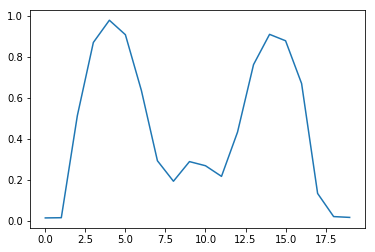

In [173]:
plt.figure()
plt.plot(X_train[51,:,10])
print(X_train[51,:,10])




ENTRENAMOS EL MODELO : 

In [174]:
ys = set(all_labels)
print(ys)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
#print(ps)
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print(predicted_labels)
print(y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])


/Users/beatrizcamposleon/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide
/Users/beatrizcamposleon/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


[0 0 2 3 0 2 0 6 6 0 0 6 0 6 2 2 3 3 3 6 1 2 6 5 0 2 3 3 1 2 0 2 6 1 3 0 0
 2 2 3 0 6 2 6 6 0 1 6 5 0 0 0 0]
[1. 4. 3. 5. 4. 2. 1. 6. 3. 0. 4. 6. 1. 3. 2. 2. 3. 5. 3. 6. 4. 2. 4. 5.
 0. 2. 5. 3. 1. 1. 0. 2. 6. 4. 5. 0. 1. 2. 2. 3. 4. 6. 5. 6. 6. 0. 4. 6.
 5. 0. 1. 1. 0.]
Test accuracy: 56.60 percent


MATRIZ DE CONFUSIÓN : 

In [175]:
print(ys)

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])


Text(0.5,0,'Predicted label')

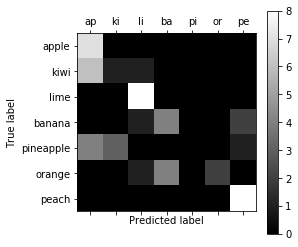

In [176]:
# ------------
# Matriz de Confusión
# ------------

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
#plt.title('Confusion matrix, single speaker')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')




OTRA FORMA DE PINTAR LA MATRIZ DE CONFUSIÓN : 

In [177]:
# Python script for confusion matrix creation. 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
actual = y_test 
predicted = predicted_labels
results = confusion_matrix(actual, predicted) 
print 'Confusion Matrix :'
print(results) 
print 'Accuracy Score :',accuracy_score(actual, predicted)*100 
print 'Report : '
print classification_report(actual, predicted, target_names= spoken) 



Confusion Matrix :
[[7 0 0 0 0 0 0]
 [6 1 1 0 0 0 0]
 [0 0 8 0 0 0 0]
 [0 0 1 4 0 0 2]
 [4 3 0 0 0 0 1]
 [0 0 1 4 0 2 0]
 [0 0 0 0 0 0 8]]
Accuracy Score : 56.60377358490566
Report : 
              precision    recall  f1-score   support

       apple       0.41      1.00      0.58         7
        kiwi       0.25      0.12      0.17         8
        lime       0.73      1.00      0.84         8
      banana       0.50      0.57      0.53         7
   pineapple       0.00      0.00      0.00         8
      orange       1.00      0.29      0.44         7
       peach       0.73      1.00      0.84         8

   micro avg       0.57      0.57      0.57        53
   macro avg       0.52      0.57      0.49        53
weighted avg       0.51      0.57      0.49        53



### EJEMPLO CÁLCULO COEFICIENTES MFCCS PARA UN AUDIO EN CONCRETO : 

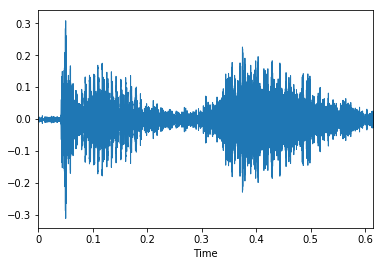

In [108]:
import librosa 
import librosa.display
import IPython.display


x, fs = librosa.load('peach01.wav')
librosa.display.waveplot(x, sr=fs)

In [220]:
IPython.display.Audio(x, rate=fs)

(20, 27)


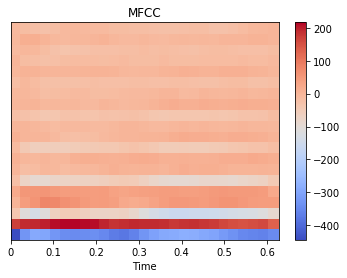

In [221]:

mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=20)
print(mfccs.shape)


#print mfccs.shape # resultado: (20, 19) -> "0 ceoficientes cada 19 frames"

######
# ------
#     Display 
# Coeficcientes MFCC
# ------

librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.title('MFCC')
plt.colorbar()


[-8.24443394e-16 -1.64477485e-17  6.25014443e-16 -7.62764337e-16
 -9.21073917e-16  6.82581563e-16  7.96687819e-18  2.44660259e-16
  1.21713339e-15  5.34551827e-17 -1.68589422e-16 -6.57909941e-17
  1.93261045e-16  3.37178845e-16 -1.02387234e-15 -1.72701359e-16
  1.23358114e-16  3.57738530e-16  0.00000000e+00  1.31581988e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


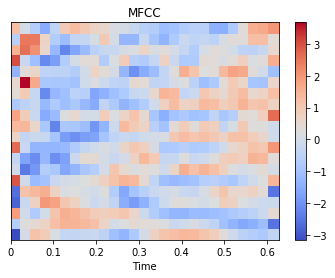

In [222]:
import sklearn

# "Normalizamos" coeficientes MFCC 
# Escalamos los coeficientes MFCC de modo que cada dimensión de coeficiente tenga media cero y
# varianza unitaria:

mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
print mfccs.mean(axis=1)
print mfccs.var(axis=1)
plt.title('MFCC')
plt.colorbar()


(20, 30)


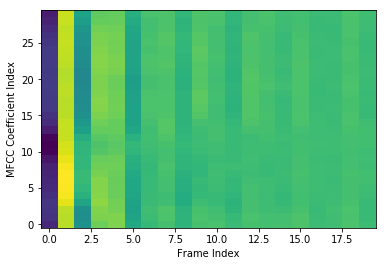

<Figure size 432x288 with 0 Axes>

In [13]:

plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')
plt.figure()

print (mfccs.shape)  # Obtenemos 20 coeficientes MFFC 
                

    # Este es un ejemplo leyendo una señal de audio, 
    # ahora tenemos que estrapolarlo a toda nuestra base de audios. De manera que el tamaño de la matriz sea: 
    # Size of training matrix: (105, 20, frames)